Para este notebook voy a utilizar el siguiente dataset con datos de diversos pacientes relacionados con la diabetes, y si tienen diabetes o no. 
La variable DiabetesPedigreeFunction contiene una funcion que calcula la probabilidad de diabetes basandose en la historia familiar
El dataset fue descargado de: https://www.kaggle.com/datasets/vikasukani/diabetes-data-set

In [34]:
#Importando librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import keras

In [35]:
#Cargando dataset y visualizando las primeras filas

df = pd.read_csv('../data/diabetes-dataset.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0
...,...,...,...,...,...,...,...,...,...
1995,2,75,64,24,55,29.7,0.370,33,0
1996,8,179,72,42,130,32.7,0.719,36,1
1997,6,85,78,0,0,31.2,0.382,42,0
1998,0,129,110,46,130,67.1,0.319,26,1


In [36]:
#Analizando el dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


In [37]:
#Eliminando outliers por medio del rango intercuartilico
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
3,0,135,68,42,250,42.3,0.365,24,1
5,0,173,78,32,265,46.5,1.159,58,0
6,4,99,72,17,0,25.6,0.294,28,0
...,...,...,...,...,...,...,...,...,...
1994,1,79,60,42,48,43.5,0.678,23,0
1995,2,75,64,24,55,29.7,0.370,33,0
1996,8,179,72,42,130,32.7,0.719,36,1
1997,6,85,78,0,0,31.2,0.382,42,0


In [38]:
df.groupby('Outcome').size()

Outcome
0    1136
1     516
dtype: int64

In [39]:
#Generando datos artificiales para balancear el dataset
from sklearn.utils import resample

df_mayor = df[df.Outcome == 0]
df_menor = df[df.Outcome == 1]

df_mayor_upsampled = resample(df_menor, replace=True, n_samples=1136, random_state=42)
df = pd.concat([df_mayor, df_mayor_upsampled])


<Axes: >

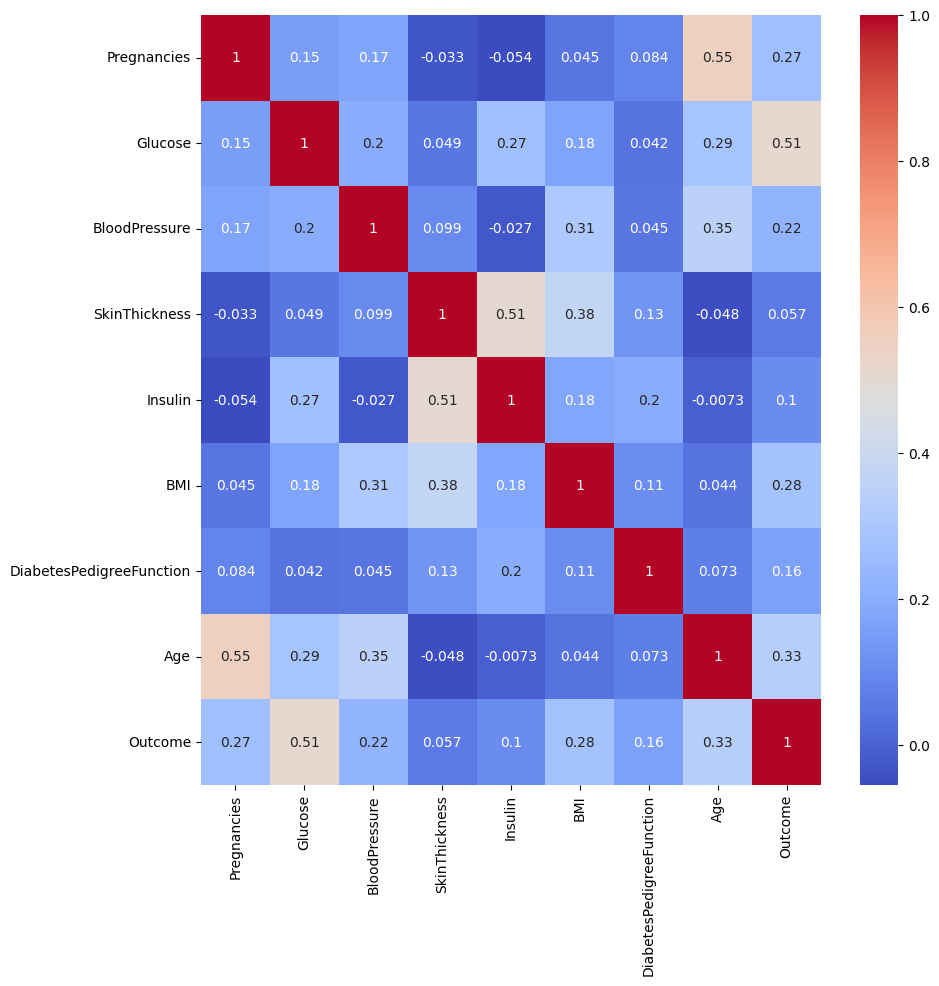

In [40]:
#Visualizando la correlacion entre las variables
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


In [41]:
#Dividiendo el dataset en datos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

X = df.drop(['Outcome', 'Insulin', 'SkinThickness', 'DiabetesPedigreeFunction', "Pregnancies"], axis=1)
y = df['Outcome']

# X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.20, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [42]:
#Escalando datos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [43]:
#Creando modelo de clasificación con redes neuronales
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

#Compilando el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Simon R\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,481 (48.75 KB)

 Trainable params: 12,001 (46.88 KB)

 Non-trainable params: 480 (1.88 KB)

In [44]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6702 - loss: 0.6085 - val_accuracy: 0.7273 - val_loss: 0.6342
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7880 - loss: 0.4586 - val_accuracy: 0.6334 - val_loss: 0.6334
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8181 - loss: 0.4066 - val_accuracy: 0.6716 - val_loss: 0.6189
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8361 - loss: 0.3830 - val_accuracy: 0.6657 - val_loss: 0.6014
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.4150 - val_accuracy: 0.8065 - val_loss: 0.5578
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8383 - loss: 0.3961 - val_accuracy: 0.8152 - val_loss: 0.5128
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8266 - loss: 0.3826 - val_accuracy: 0.8475 - val_loss: 0.4675
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8604 - loss: 0.3397 - val_accuracy: 0.8446 - v

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


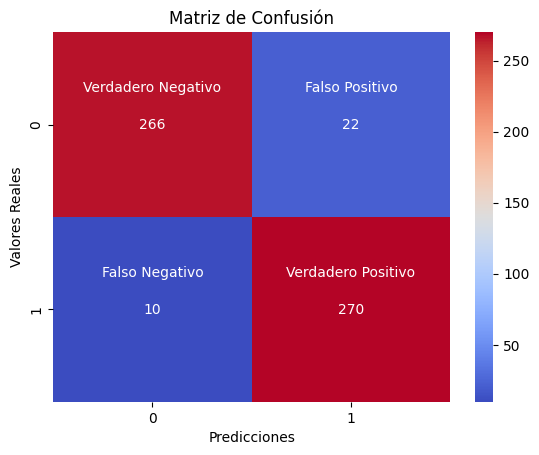

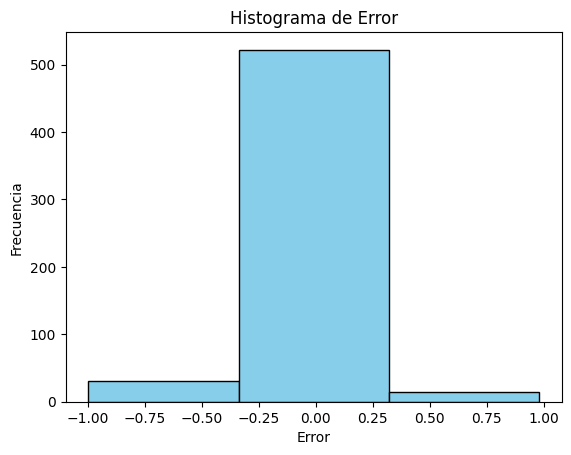

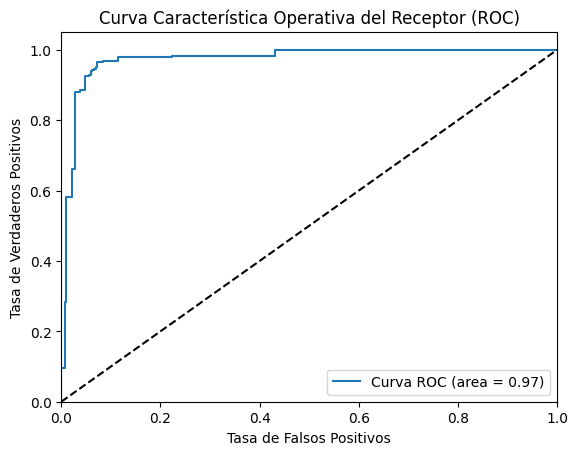

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).flatten()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Definir las etiquetas
etiquetas = ['Verdadero Negativo', 'Falso Positivo', 'Falso Negativo', 'Verdadero Positivo']

# Graficar el heatmap
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='coolwarm')

# Agregar las etiquetas dentro de cada cuadrado
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j + 0.5, i + 0.3, etiquetas[i * cm.shape[0] + j],
                       ha="center", va="center", color="white")

plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

# Histogram of errors
error = y_test - y_pred.flatten()
plt.figure()
plt.hist(error, color='skyblue', edgecolor='black', bins=3)
plt.title('Histograma de Error')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, label=f'Curva ROC (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva Característica Operativa del Receptor (ROC)')
plt.legend(loc="lower right")
plt.show()